In [3]:
pip install flopy

Note: you may need to restart the kernel to use updated packages.


# Transient

## Model Description 
This intially constructs the 3D (homogeneous) steady state box model that you built for your BoxModel_Manual assignment

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 10 m
- dz = 50 m  
- the model is unconfined

#### Subsurface Properties: 
- Homogeneous 
- K = 0.1 m/day in x, y and z 
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is a constant head of 30 m relative to the datum, which is located at the bottom of the domain. 
 - Left boundary is a constant head of 50 m relative to the datum, which is located at the bottom of the domain. 
 - Recharge occurs at a rate of 1E-5 m/d uniformly across the domain
 - There is no ET in the domain

#### Initial Conditions: 
 - Set the initial head to 50 everywhere, which will be replaced by the initial steady state solution

#### Pumpinmg
 - Well located at row, column 20,20
     - There is no pumping during the initial steady state period
     - Case 1: pumps at a rate of 500 m3/d for 90 days, then zero for remaining 270 days of the year for 50 years. (Assume a 360 day year made of 12 30-day months for simplicity of plotting.)

#### The Challenges
  - The gradient is not uniform for the initial steady state conditions - discuss the influences of recharge and the unconfined condition on this nonlinearity
  - Determine if the system has reached steady state - consider a point at the well and another at the center of the domain.  
  - Find the zone of influence of the well defined in two ways:
      - Based on the drawdown from the initial steady state to the end of simulation time (end of final no-pumping stress period).
      - Based on the drawdown from the end of the last pump-on stress period to the end of simulation time.
  - How long does it take a point at the center of the domain to reach steady state.  At that point, explain how you could divide the domain into a steady and transient part and solve each separately.
  - Find a constant pumping rate (same throughout the year) that matches the head time series at the middle of the domain.  
  - Find a constant pumping rate (same throughout the year) that matches the head time series at the well, leaving only a regular, repeating seasonal residual.  Are the two pumping rates the same?
  - Discuss the sources of water captured by this well.  If you're up for a challenge, calculate them for the final pump-on period!
  - Discuss how you would define the capture zone of the well.  How is it different than our definitions of capture zone so far in the course?



## 1. Setup the environment

In [4]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Create the model object

In [5]:
modelname = "results/Transients" # this part important - QH
# *NOTE Be careful about where things be located!
moddir="../../../pymake/examples/mf2005" # this part important - QH
m = flopy.modflow.Modflow(modelname, exe_name=moddir)


In [6]:
#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg', '.wel', 'rch','evt']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 

#### 3.1 Spatial discretization

In [7]:
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 1  #number of layers

dx= 10 #width of grid cells in x direction 
dy= 10 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 50.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

domain_centerpt = (0, int(nrow/2), int(ncol/2))   # used for plotting

#### 3.2 Temporal discretization 

In [8]:
# reset for steady state
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type


#### 3.3 Create DIS object

In [9]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#### 3.4 Plot the grid

For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

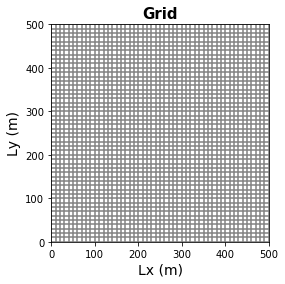

In [10]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()


## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

#### 4.1 Define cell activity: IBOUND 

In [11]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 


#### 4.2 Define starting heads 

In [12]:
#setup initial heads as 70 everywhere, this value will be preserved on constant head boundaries  
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = 50    # set all values to uniform initial condition
H_init[:, :, -1] = 30    #replace last (left) col with desired head value


#### 4.3 Create BAS object

In [13]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

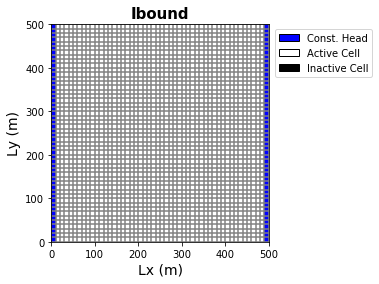

In [14]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)


# I'm not sure why this stopped working!  Can someone figure out why the right boundary doesn't show up as constant head??

## 5. Setup Layer Properties  (LPF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html

#### 5.1 Set layer properties

In [15]:
K_horiz = 0.1    #horizontal hydraulic conductivity 
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.03        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

#### 5.2 Make LPF object

In [16]:
# kept in case you want to use it later

#assigns horizontal and vertical Ks and saves cell-by-cell budget data
# lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
#                                vka=K_vert, ss=Ss,
#                                sy=Sy,storagecoefficient=True, ipakcb=53) 


## 5b. Setup Cell-byCell Properties  (BCF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbcf.html

#### 5b.1 Set cell properties and show K in top layer

1.0


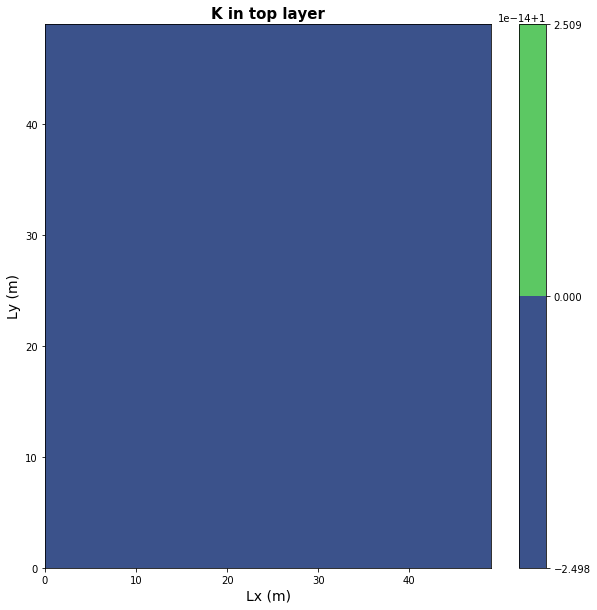

In [17]:
K_vals = np.zeros((ncol,nrow,nlay))
K_vals[:,:,:] = 1           # homoogeneous background hydraulic conductivity 
#K_vals[10:15,10:15,:] = 0.1   # low K inclusion

print(K_vals[0,0,0])

#plot K values in top layer
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('K in top layer', fontsize = 15, fontweight = 'bold')
plt.contourf(K_vals[:,:,0])
plt.colorbar()
plt.show()

#### 5b.2 Make BCF object

In [18]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[:,:,0], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### 6.1 Setup outputs

In [19]:
#create oc stress period data - save for each time step in each stress period. 

# reset for steady state
oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", oc_spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


#### 6.2 Make OC object 

In [20]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [21]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfwel.html

#### 8.1 Setup the well parameters (use this to set a defined flux boundary)

In [22]:
# reset for steady state
well_loc = [0, 20, 20]
Q = -250
fluxes = [well_loc[0],well_loc[1],well_loc[2],Q]
sp_fluxes = {0: fluxes} 

#### 8.2 Make the WEL object

In [23]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=sp_fluxes)  #create object for WEL package

##9. Add recharge (RCH Package)

For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfrch.html

#### 9.1 Setup recharge value

In [24]:
#Recharge 
rech_zone = np.ones((nrow,ncol))               #define an array of zeros of dim (nrow,ncol) - backgroun ET is zero everywhere
recharge = 5e-4 #m/day                          
rech_zone = rech_zone*recharge
print(rech_zone)

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


[[0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 ...
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]]


## 10. Write inputs and run the model 

#### 10.1 Write Inputs

In [25]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 10.2 Run the model

In [26]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: ../../../pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: results/Transients.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/29 17:35:09

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/03/29 17:35:09
 Elapsed run time:  0.016 Seconds

  Normal termination of simulation


## Add Particles to both scenarios

[[0, 0, 0, 0, -1, 0]]
FloPy is using the following  executable to run the model: ../../../pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: results/Transients_mp_forward.mpsim 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/29 17:35:09


 CANNOT OPEN   ON UNIT   0 BECAUSE UNIT IS ALREADY BEING USED
[1020]


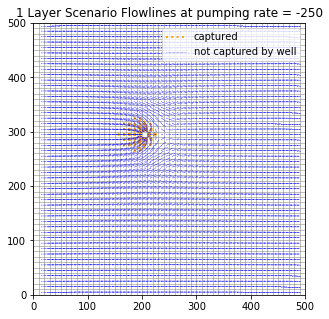

In [27]:
# create modpath files
mpdir="../../../pymake/examples/mp7"  
nm = modelname
mpnamb = nm + '_mp_forward'

#Make a group of particles - note we can use these for both simulations
# the whole left boundary
locsb = [[0, 0, 0, 0, -1, 0]] #Set the range of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
print(locsb)
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=3, rowcelldivisions=3, layercelldivisions=3) #Number of part per cell
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb]) #setup theparticles
pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg1]

# defaultiface = {'RECHARGE': 6, 'ET': 6} # ?

mp = flopy.modpath.Modpath7(modelname=mpnamb, flowmodel=m, exe_name=moddir)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n) #, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend')  
                                  # particlegroups= particlegroups)


# mp.add_package(rch)
mp.write_input()
mp.run_model()
mp.get_package_list()

# backward tracking pathlines
fpth = os.path.join(mpnamb + '.mppth')
p = flopy.utils.PathlineFile(fpth)

# backward tracking endpionts
fpth = os.path.join(mpnamb + '.mpend')
e = flopy.utils.EndpointFile(fpth)

#make a subset which is all the particles
pall1 = p.get_alldata()  
eall1 = e.get_alldata()

# make a subset which is particles ending in the well
nodewell = m.dis.get_node([well_loc])
print(nodewell)
pwell1 = p.get_destination_pathline_data(dest_cells=nodewell)
ewell1 = e.get_destination_endpoint_data(dest_cells=nodewell)

#### 1 layered model 
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_aspect('equal')
ax.set_title('1 Layer Scenario Flowlines at pumping rate = '+str(Q))
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pwell1, layer='all', color='orange', lw=2.0, linestyle=':', label='captured') # ,marker='o', 
mm.plot_pathline(pall1, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by well') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.ax.legend();

## 11. Plot the results  

#### 11.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile



In [31]:
# QH - Moving Average:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


# Read the heads 
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data

# hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
# times = hds.get_times() # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
head = []
headarray=np.zeros((len(times),ncol,nrow))
frf=np.zeros((len(times),ncol,nrow))
fff=np.zeros((len(times),ncol,nrow))
# rowcounter=-1
# for i in times:
#     rowcounter+=1
#     temphead = headobj.get_data(totim=i) #append heads to head list for each stress per
#     headarray[rowcounter,:,:] = temphead
#     tempfrf = np.squeeze(budgobj.get_data(text='flow right face',totim=i))
#     # print(tempfrf)
#     frf[rowcounter,:,:] = tempfrf
#     tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE',totim=i))
#     fff[rowcounter,:,:] = tempfff

# # # extract and plot head time series at specific points
# # time_series1 = headarray[:,domain_centerpt[1],domain_centerpt[2]]
# # time_series2 = headarray[:,well_loc[1],well_loc[2]]


# # n_in = 8
# # time_series1_mv = moving_average(time_series1,n_in)
# # time_series2_mv = moving_average(time_series2,n_in)
# # elyears_mv = elyears[int(n_in/2)-1:-int(n_in/2)]

# # tol = 5e-5 # the tolerance to set as 'steady'
# # # locate steady state
# # time_series1_mv_diff = time_series1_mv[:-1] - time_series1_mv[1:]
# # time_series2_mv_diff = time_series2_mv[:-1]  - time_series2_mv[1:]

# # # first year where head does not change
# # print('the first steady state year at well is,', elyears_mv[:-1][time_series1_mv_diff < tol][0])
# # print('the first steady state year at midpoint is,', elyears_mv[:-1][time_series2_mv_diff <= tol][0])

# # # organize 
# # hds = [] # hds at well
# # yrs = [25, 50, 75, 100]
# # for yr in yrs:
# #     print('year', yr)
# #     if yr == 100:
# #         inx = int(len(elyears_mv)-1)
# #     else:
# #         inx = int(np.where(elyears_mv == yr)[0])
# #     print('index at', inx)
# #     hds.append(time_series2_mv[inx])

# # print('steady state heads for yr', yrs, '\n are', hds)
    


# # # QH Extra Time Series 
# # pumping 250
# # time_series5 = headarray[:,well_loc[1],well_loc[2]]
# # pumping 260
# time_series6 = headarray[:,well_loc[1],well_loc[2]]

# fig1 = plt.figure(figsize=(10,10))
# plt.title("Head at well",fontweight='bold')
# plt.xlabel('time (years)',fontweight='bold')
# plt.ylabel('head (m)',fontweight='bold')
# # plt.xlim(0,2)

# # plt.plot(elyears, time_series2, 'r-', alpha=0.3, label='var pumping, 500 m/d') #plot the time series with points at each record
# # plt.plot(elyears, time_series4, label='const 250 m/d')
# # plt.plot(elyears_mv, time_series2_mv, 'black', alpha = 0.5, label='moving avg')
# # for i in range(len(yrs)):
# #     plt.plot([0, 100], [hds[i], hds[i]], alpha = 0.5, label='representative head at year '+str(yrs[i]))
# # plt.plot(elyears, time_series5, alpha=0.8, label='const pumping, 250 m/d - yr 25', linewidth='3')
# plt.plot(elyears, time_series6, alpha=0.8, label='const pumping, 255 m/d - yrs >= 50', linewidth='3')

# plt.legend()
# plt.show()

# # fig2 = plt.figure(figsize=(10,10))
# # plt.title("Head at midpoint",fontweight='bold')
# # plt.xlabel('time (years)',fontweight='bold')
# # plt.ylabel('head (m)',fontweight='bold')
# # plt.plot(elyears, time_series1, 'r-', alpha = 0.8, label='var 500 m/d') #plot the time series with points at each record
# # # plt.plot(elyears, time_series3, label='const 250 m/d')
# # plt.plot(elyears_mv, time_series1_mv, 'black', alpha = 0.8, label='moving avg')
# # plt.legend()
# # plt.show()




## Plot head distributions after initial steady state, after final off pumping period, and at end of simulation

In [32]:
## Plot head cross section through well after initial steady state, after final off pumping period, and at end of simulation

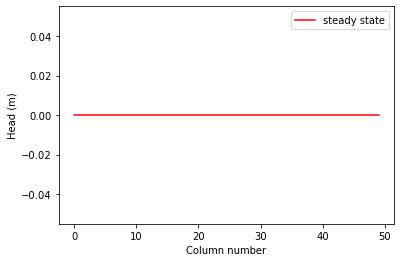

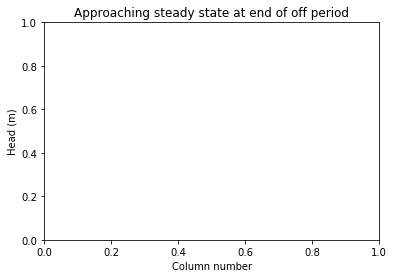

In [33]:
#plot head distribution at years 0, half of sim time, end of sim time
# initsteady = headarray[0,20,:]
plt.plot(np.arange(nrow),headarray[0,20,:],'r',label='steady state')
# plt.plot(np.arange(nrow),headarray[-2,20,:],'b',label='final off')
# plt.plot(np.arange(nrow),headarray[-1,20,:],'g',label='final time')
# plt.plot(np.arange(nrow),initsteady,'b-',label='steady state')
plt.xlabel('Column number')
plt.ylabel('Head (m)')
plt.legend()
plt.show()


for i in range(1,headarray.shape[0], 2):
    plt.plot(np.arange(nrow),headarray[i,20,:],alpha=0.2)

plt.xlabel('Column number')
plt.ylabel('Head (m)')
plt.title('Approaching steady state at end of off period')
plt.show()



In [34]:
#plot head distribution at years 0, half of sim time, end of sim time
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[0,:,:], levels=contour_levels) #create head contours   
tempfrf3 = frf[0,:,:].reshape(1,ncol,nrow)
tempfff3 = fff[0,:,:].reshape(1,ncol,nrow)
temphead3 = headarray[0,:,:].reshape(1,ncol,nrow)
flows = modelmap.plot_discharge(tempfrf3, tempfff3, head=temphead3) #create discharge arrows
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Head (m) at initial steady state', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

# fig2 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
# modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# # grid = modelmap.plot_grid() #plot model grid
# qm = modelmap.plot_ibound()  
# contour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head
# head_contours = modelmap.contour_array(headarray[-1,:,:], levels=contour_levels) #create head contours   
# tempfrf1 = frf[-1,:,:].reshape(1,ncol,nrow)
# tempfff1 = fff[-1,:,:].reshape(1,ncol,nrow)
# temphead1 = headarray[-1,:,:].reshape(1,ncol,nrow)
# flows = modelmap.plot_discharge(tempfrf1, tempfff1, head=temphead1) #create discharge arrows
# plt.xlabel('Lx (m)',fontsize = 14)
# plt.ylabel('Ly (m)',fontsize = 14)
# plt.title('Head (m) at end of simulation', fontsize = 15, fontweight = 'bold')
# plt.colorbar(head_contours,aspect=5)

# fig3 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
# modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# # grid = modelmap.plot_grid() #plot model grid
# qm = modelmap.plot_ibound()  
# contour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head
# head_contours = modelmap.contour_array(headarray[-2,:,:], levels=contour_levels) #create head contours   
# tempfrf2 = frf[-2,:,:].reshape(1,ncol,nrow)
# tempfff2 = fff[-2,:,:].reshape(1,ncol,nrow)
# temphead2 = headarray[-2,:,:].reshape(1,ncol,nrow)
# flows = modelmap.plot_discharge(tempfrf2, tempfff2, head=temphead2) #create discharge arrows
# plt.xlabel('Lx (m)',fontsize = 14)
# plt.ylabel('Ly (m)',fontsize = 14)
# plt.title('Head (m) at end of final off period', fontsize = 15, fontweight = 'bold')
# plt.colorbar(head_contours,aspect=5)



/Users/roberthull/opt/miniconda3/envs/Res1/lib/python3.8/site-packages/flopy/plot/map.py:345: UserWarning: No contour levels were found within the data range.
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


IndexError: index 2 is out of bounds for axis 0 with size 2

## Plot drawdown

In [ ]:
#plot change in head distribution between steady state and final time
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_min = np.min(headarray[0,:,:]-headarray[-1,:,:])
contour_max = np.max(headarray[0,:,:]-headarray[-1,:,:])
contour_levels = np.linspace(contour_min,contour_max,21) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[0,:,:]-headarray[-1,:,:], levels=contour_levels) #create head contours   
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Drawdown (m) from steady state to final time', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

# #plot change in head distribution between steady state and final time
# fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
# modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# # grid = modelmap.plot_grid() #plot model grid
# qm = modelmap.plot_ibound()  
# contour_min = np.min(headarray[-2,:,:]-headarray[-1,:,:])
# contour_max = np.max(headarray[-2,:,:]-headarray[-1,:,:])
# contour_levels = np.linspace(contour_min,contour_max,21) #set contour levels for contouring head
# head_contours = modelmap.contour_array(headarray[-2,:,:]-headarray[-1,:,:], levels=contour_levels) #create head contours   
# plt.xlabel('Lx (m)',fontsize = 14)
# plt.ylabel('Ly (m)',fontsize = 14)
# plt.title('Drawdown (m) from final off to final time', fontsize = 15, fontweight = 'bold')
# plt.colorbar(head_contours,aspect=5)

